In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import nltk
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Constants
CSV_FILE_PATH = 'utterance.csv'
KEYWORDS_CSV_FILE_PATH = 'keywords.csv'
TOP_N_KEYWORDS = 200
NGRAM_RANGE = (1, 3)
TOP_PREDICT = 1


def load_data(file_path):
    """Load and preprocess data from a CSV file."""
    data = pd.read_csv(file_path)
    data['utterance'] = data['utterance'].apply(lambda x: preprocess_text(x, stop_words))
    return data

def get_wordnet_pos(tag):
    """Map NLTK POS tags to WordNet POS tags."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocess_text(text, stop_words):
    """Preprocess text by tokenizing, removing stopwords, and lemmatizing."""
    try:
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
        pos_tags = nltk.pos_tag(tokens)
        lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
        return ' '.join(lemmatized_tokens)
    except Exception as e:
        logging.error(f"Error processing text: {e}")
        return text


def split_data(data):
    """Split data into training and testing sets."""
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=41)
    for train_index, test_index in split.split(data, data['intent']):
        train_data = data.loc[train_index]
        test_data = data.loc[test_index]
    return train_data, test_data


def extract_and_save_keywords(train_data, stop_words, max_features=TOP_N_KEYWORDS, ngram_range=NGRAM_RANGE, output_file=KEYWORDS_CSV_FILE_PATH):
    """Extract and save keywords to a CSV file."""
    keywords_list = []

    for (category, intent) in train_data[['category', 'intent']].drop_duplicates().itertuples(index=False):
        intent_data = train_data[(train_data['category'] == category) & (train_data['intent'] == intent)]
        intent_vectorizer = TfidfVectorizer(max_features=max_features, stop_words=list(stop_words), ngram_range=ngram_range)
        intent_X = intent_vectorizer.fit_transform(intent_data['utterance'])
        feature_names = intent_vectorizer.get_feature_names_out()
        tfidf_scores = intent_X.mean(axis=0).A1  # Average TF-IDF scores for each keyword

        for keyword, score in zip(feature_names, tfidf_scores):
            keywords_list.append({
                'category': category,
                'intent': intent,
                'keyword': keyword,
                'tfidf score': score
            })

    keywords_df = pd.DataFrame(keywords_list)
    keywords_df.to_csv(output_file, index=False)


    print(f"Keywords have been extracted and saved to '{output_file}'.")


def get_top_n_intents(utterance, keywords_dict, n=TOP_PREDICT):
    """Get the top N intents for a given utterance."""
    words = set(utterance.split())
    intent_scores = {intent: len(words & keywords) for intent, keywords in keywords_dict.items()}
    sorted_intents = sorted(intent_scores, key=intent_scores.get, reverse=True)[:n]

    return sorted_intents, words & keywords_dict[sorted_intents[0]]


def identify_inaccurate_keywords(test_data):
    """Identify the most common inaccurate keywords and their associated intents."""
    mismatches = test_data[test_data['is_accurate'] == False]
    keyword_intent_pairs = mismatches.explode('keywords_used')[['keywords_used', 'intent']]
    keyword_intent_counts = keyword_intent_pairs.value_counts().reset_index(name='Count')
    keyword_intent_counts.columns = ['Keyword', 'Intent', 'Count']
    most_inaccurate_keywords = keyword_intent_counts.head(10)
    
    return most_inaccurate_keywords

def predict_intents(test_data, keywords_dict, top_predict=TOP_PREDICT):
    """Predict top N intents and calculate accuracy."""
    test_data['top_predict_intents'], test_data['keywords_used'] = zip(*test_data['utterance'].apply(lambda x: get_top_n_intents(x, keywords_dict, n=top_predict)))
    test_data['is_accurate'] = test_data.apply(lambda row: row['intent'] in row['top_predict_intents'], axis=1)
    accuracy_score_value = test_data['is_accurate'].mean()
    logging.info(f"Accuracy Score: {accuracy_score_value * 100:.2f}%")
    return test_data


# Load and preprocess data
data = load_data(CSV_FILE_PATH)

# Split data
train_data, test_data = split_data(data)

# Extract and save keywords
extract_and_save_keywords(train_data, stop_words)

# Load keywords
keywords_df = pd.read_csv(KEYWORDS_CSV_FILE_PATH)
keywords_dict = {}
for _, row in keywords_df.iterrows():
    if row['intent'] not in keywords_dict:
        keywords_dict[row['intent']] = set()
    keywords_dict[row['intent']].add(row['keyword'])

# Predict top N intents for the test data
test_data = predict_intents(test_data, keywords_dict)

# Identify inaccurate keywords
most_inaccurate_keywords = identify_inaccurate_keywords(test_data)
display(most_inaccurate_keywords)

# Extract the most common inaccurate keywords to use as stopwords for each intent
new_stopwords_dict = most_inaccurate_keywords.set_index('Intent')['Keyword'].to_dict()

# Save the new stopwords to a file
with open('new_stopwords.txt', 'w') as f:
    for intent, word in new_stopwords_dict.items():
        f.write(f"{intent}: {word}\n")
logging.info("New stopwords have been saved to 'new_stopwords.txt'.")

# Update the stopwords with the new stopwords per intent
updated_stop_words = stop_words.union(new_stopwords_dict.values())

# Apply the updated preprocessing function to the utterance data
data['utterance'] = data['utterance'].apply(lambda x: preprocess_text(x, updated_stop_words))

# Remove the new stopwords from the keywords for the associated intents
for intent, stopword in new_stopwords_dict.items():
    if intent in keywords_dict:
        keywords_dict[intent].discard(stopword)

# Predict top N intents for the test data again with updated stopwords
test_data = predict_intents(test_data, keywords_dict)

# Identify inaccurate keywords
most_inaccurate_keywords = identify_inaccurate_keywords(test_data)
display(most_inaccurate_keywords)

Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 08:19:33,141 - INFO - Accuracy Score: 97.70%


,Keyword,Intent,Count
0,see,get_invoice,31
1,account,create_account,20
2,invoice,get_invoice,16
3,bill,get_invoice,14
4,information,get_invoice,11
5,make,place_order,10
6,ask,get_invoice,10
7,want,get_invoice,10
8,agent,get_invoice,8
9,help,create_account,8


2024-09-26 08:19:33,152 - INFO - New stopwords have been saved to 'new_stopwords.txt'.
2024-09-26 08:19:38,453 - INFO - Accuracy Score: 96.80%


,Keyword,Intent,Count
0,ask,get_invoice,38
1,agent,get_invoice,37
2,see,get_invoice,31
3,account,create_account,27
4,invoice,get_invoice,25
5,bill,get_invoice,20
6,help,create_account,18
7,information,get_invoice,16
8,could,get_invoice,11
9,make,place_order,10


In [29]:
# Parameter grid
ngram_ranges = [(1, 1), (1, 2), (1, 3)]
top_n_keywords_list = [10, 25, 50, 100, 150, 200, 400, 600, 800, 1000]


# Function to run the entire process with given parameters
def run_process(ngram_range, top_n_keywords):
    # Load and preprocess data
    data = load_data(CSV_FILE_PATH)
    
    # Split data
    train_data, test_data = split_data(data)
    
    # Extract and save keywords
    extract_and_save_keywords(train_data, stop_words, max_features=top_n_keywords, ngram_range=ngram_range)
    
    # Load keywords
    keywords_df = pd.read_csv(KEYWORDS_CSV_FILE_PATH)
    keywords_dict = {}
    for _, row in keywords_df.iterrows():
        if row['intent'] not in keywords_dict:
            keywords_dict[row['intent']] = set()
        keywords_dict[row['intent']].add(row['keyword'])
    
    # Predict top N intents for the test data
    test_data = predict_intents(test_data, keywords_dict)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_data['intent'], test_data['top_predict_intents'].apply(lambda x: x[0]))
    
    return accuracy

# List to store results
results = []

# Iterate over the parameter grid
for ngram_range in ngram_ranges:
    for top_n_keywords in top_n_keywords_list:
        accuracy = run_process(ngram_range, top_n_keywords)
        results.append({
            'ngram_range': ngram_range,
            'top_n_keywords': top_n_keywords,
            'accuracy': accuracy
        })
        logging.info(f"ngram_range: {ngram_range}, top_n_keywords: {top_n_keywords}, accuracy: {accuracy:.2f}")

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Identify the best combination
best_result = results_df.loc[results_df['accuracy'].idxmax()]
logging.info(f"Best combination: ngram_range={best_result['ngram_range']}, top_n_keywords={best_result['top_n_keywords']}, accuracy={best_result['accuracy']:.2f}")

# Display the results
print(results_df)
print(f"Best combination: ngram_range={best_result['ngram_range']}, top_n_keywords={best_result['top_n_keywords']}, accuracy={best_result['accuracy']:.2f}")

2024-09-26 07:51:00,884 - INFO - Accuracy Score: 87.35%
2024-09-26 07:51:00,890 - INFO - ngram_range: (1, 1), top_n_keywords: 10, accuracy: 0.87


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:07,388 - INFO - Accuracy Score: 96.80%


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:07,394 - INFO - ngram_range: (1, 1), top_n_keywords: 25, accuracy: 0.97
2024-09-26 07:51:13,667 - INFO - Accuracy Score: 97.38%
2024-09-26 07:51:13,674 - INFO - ngram_range: (1, 1), top_n_keywords: 50, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:20,078 - INFO - Accuracy Score: 96.89%
2024-09-26 07:51:20,084 - INFO - ngram_range: (1, 1), top_n_keywords: 100, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:26,371 - INFO - Accuracy Score: 96.87%
2024-09-26 07:51:26,377 - INFO - ngram_range: (1, 1), top_n_keywords: 150, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:32,608 - INFO - Accuracy Score: 96.87%
2024-09-26 07:51:32,614 - INFO - ngram_range: (1, 1), top_n_keywords: 200, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:38,969 - INFO - Accuracy Score: 96.87%
2024-09-26 07:51:38,975 - INFO - ngram_range: (1, 1), top_n_keywords: 400, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:45,301 - INFO - Accuracy Score: 96.87%
2024-09-26 07:51:45,307 - INFO - ngram_range: (1, 1), top_n_keywords: 600, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:51,580 - INFO - Accuracy Score: 96.87%
2024-09-26 07:51:51,586 - INFO - ngram_range: (1, 1), top_n_keywords: 800, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:51:58,007 - INFO - Accuracy Score: 96.87%
2024-09-26 07:51:58,013 - INFO - ngram_range: (1, 1), top_n_keywords: 1000, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:04,507 - INFO - Accuracy Score: 85.74%
2024-09-26 07:52:04,513 - INFO - ngram_range: (1, 2), top_n_keywords: 10, accuracy: 0.86


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:10,737 - INFO - Accuracy Score: 93.17%
2024-09-26 07:52:10,744 - INFO - ngram_range: (1, 2), top_n_keywords: 25, accuracy: 0.93


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:17,055 - INFO - Accuracy Score: 96.15%
2024-09-26 07:52:17,062 - INFO - ngram_range: (1, 2), top_n_keywords: 50, accuracy: 0.96


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:23,585 - INFO - Accuracy Score: 97.65%
2024-09-26 07:52:23,591 - INFO - ngram_range: (1, 2), top_n_keywords: 100, accuracy: 0.98


Keywords have been extracted and saved to 'keywords.csv'.
Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:30,051 - INFO - Accuracy Score: 97.19%
2024-09-26 07:52:30,058 - INFO - ngram_range: (1, 2), top_n_keywords: 150, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:36,622 - INFO - Accuracy Score: 97.38%
2024-09-26 07:52:36,628 - INFO - ngram_range: (1, 2), top_n_keywords: 200, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:43,169 - INFO - Accuracy Score: 96.87%
2024-09-26 07:52:43,176 - INFO - ngram_range: (1, 2), top_n_keywords: 400, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:49,601 - INFO - Accuracy Score: 96.87%
2024-09-26 07:52:49,608 - INFO - ngram_range: (1, 2), top_n_keywords: 600, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:52:56,619 - INFO - Accuracy Score: 96.87%
2024-09-26 07:52:56,625 - INFO - ngram_range: (1, 2), top_n_keywords: 800, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:03,121 - INFO - Accuracy Score: 96.87%
2024-09-26 07:53:03,128 - INFO - ngram_range: (1, 2), top_n_keywords: 1000, accuracy: 0.97
2024-09-26 07:53:09,340 - INFO - Accuracy Score: 85.74%
2024-09-26 07:53:09,346 - INFO - ngram_range: (1, 3), top_n_keywords: 10, accuracy: 0.86


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:15,563 - INFO - Accuracy Score: 93.20%
2024-09-26 07:53:15,569 - INFO - ngram_range: (1, 3), top_n_keywords: 25, accuracy: 0.93


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:21,809 - INFO - Accuracy Score: 95.38%
2024-09-26 07:53:21,816 - INFO - ngram_range: (1, 3), top_n_keywords: 50, accuracy: 0.95


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:28,261 - INFO - Accuracy Score: 97.40%


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:28,268 - INFO - ngram_range: (1, 3), top_n_keywords: 100, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:34,757 - INFO - Accuracy Score: 97.54%
2024-09-26 07:53:34,763 - INFO - ngram_range: (1, 3), top_n_keywords: 150, accuracy: 0.98


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:41,251 - INFO - Accuracy Score: 97.70%
2024-09-26 07:53:41,258 - INFO - ngram_range: (1, 3), top_n_keywords: 200, accuracy: 0.98


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:47,861 - INFO - Accuracy Score: 97.40%
2024-09-26 07:53:47,867 - INFO - ngram_range: (1, 3), top_n_keywords: 400, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:53:55,295 - INFO - Accuracy Score: 97.24%
2024-09-26 07:53:55,301 - INFO - ngram_range: (1, 3), top_n_keywords: 600, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:54:02,261 - INFO - Accuracy Score: 96.89%
2024-09-26 07:54:02,268 - INFO - ngram_range: (1, 3), top_n_keywords: 800, accuracy: 0.97


Keywords have been extracted and saved to 'keywords.csv'.


2024-09-26 07:54:09,057 - INFO - Accuracy Score: 96.84%
2024-09-26 07:54:09,064 - INFO - ngram_range: (1, 3), top_n_keywords: 1000, accuracy: 0.97
2024-09-26 07:54:09,066 - INFO - Best combination: ngram_range=(1, 3), top_n_keywords=200, accuracy=0.98


   ngram_range  top_n_keywords  accuracy
0       (1, 1)              10  0.873462
1       (1, 1)              25  0.967959
2       (1, 1)              50  0.973764
3       (1, 1)             100  0.968888
4       (1, 1)             150  0.968656
5       (1, 1)             200  0.968656
6       (1, 1)             400  0.968656
7       (1, 1)             600  0.968656
8       (1, 1)             800  0.968656
9       (1, 1)            1000  0.968656
10      (1, 2)              10  0.857441
11      (1, 2)              25  0.931739
12      (1, 2)              50  0.961458
13      (1, 2)             100  0.976550
14      (1, 2)             150  0.971906
15      (1, 2)             200  0.973764
16      (1, 2)             400  0.968656
17      (1, 2)             600  0.968656
18      (1, 2)             800  0.968656
19      (1, 2)            1000  0.968656
20      (1, 3)              10  0.857441
21      (1, 3)              25  0.931971
22      (1, 3)              50  0.953796
23      (1, 3)  

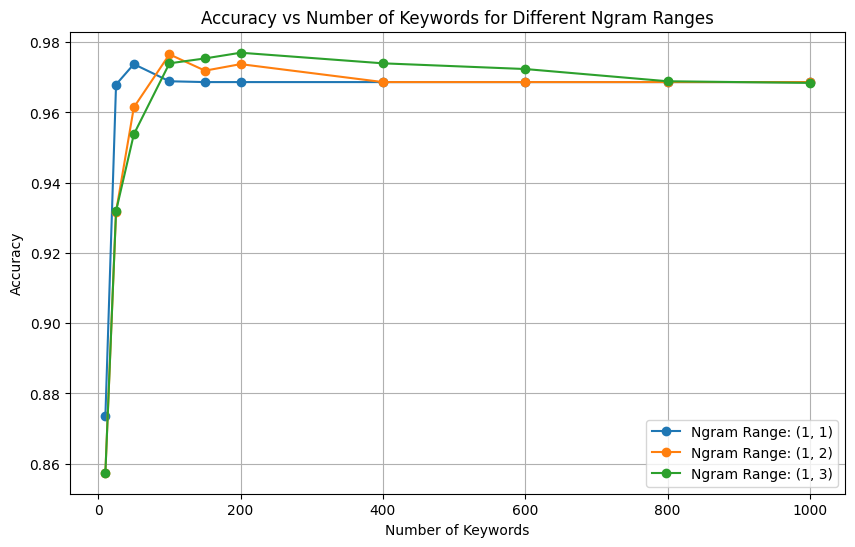

In [30]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot each ngram range as a separate line
for ngram_range in results_df['ngram_range'].unique():
    subset = results_df[results_df['ngram_range'] == ngram_range]
    plt.plot(subset['top_n_keywords'], subset['accuracy'], marker='o', label=f'Ngram Range: {ngram_range}')

# Add labels and title
plt.xlabel('Number of Keywords')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Keywords for Different Ngram Ranges')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()